In [3]:
"""
Sobol Initialization Quality vs BO Performance Study
====================================================
Tests whether initial design quality metrics predict optimization outcomes.
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from scipy.stats import qmc, pearsonr, spearmanr
from scipy.spatial.distance import pdist

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

# ====================================================================
#                    LOOKUP TABLE LOADER
# ====================================================================

class LookupTable:
    def __init__(self, X, y, feature_names=None):
        """
        X: (N, d) tensor of features (normalized to [0,1])
        y: (N,) tensor of objectives
        """
        self.X = X.to(device=DEVICE, dtype=DTYPE)
        self.y = y.to(device=DEVICE, dtype=DTYPE)
        self.n, self.d = X.shape
        self.feature_names = feature_names or [f"x{i+1}" for i in range(self.d)]

def load_lookup_csv(path: str, impute_features='median') -> LookupTable:
    """Load CSV where last column is objective, others are features."""
    df = pd.read_csv(path)
    
    feat_cols = list(df.columns[:-1])
    obj_col = df.columns[-1]
    
    # Coerce to numeric
    for c in feat_cols + [obj_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with invalid objective
    mask_y = df[obj_col].notna()
    
    if impute_features == 'median':
        med = df.loc[mask_y, feat_cols].median(numeric_only=True)
        df.loc[:, feat_cols] = df[feat_cols].fillna(med)
        mask_x = df[feat_cols].notna().all(axis=1)
    else:
        mask_x = df[feat_cols].notna().all(axis=1)
    
    df_clean = df.loc[mask_y & mask_x].reset_index(drop=True)
    
    if df_clean.shape[0] < 5:
        raise ValueError("Fewer than 5 valid rows. Check your CSV.")
    
    X_np = df_clean[feat_cols].to_numpy(dtype=np.float64)
    y_np = df_clean[obj_col].to_numpy(dtype=np.float64)
    
    # Normalize to [0,1]
    X_min = X_np.min(axis=0)
    X_max = X_np.max(axis=0)
    X_range = np.maximum(X_max - X_min, 1e-12)
    X_norm = (X_np - X_min) / X_range
    
    X = torch.tensor(X_norm, dtype=DTYPE, device=DEVICE)
    y = torch.tensor(y_np, dtype=DTYPE, device=DEVICE)
    
    return LookupTable(X, y, feature_names=feat_cols)

# ====================================================================
#              INITIALIZATION QUALITY METRICS
# ====================================================================

def evaluate_initialization_quality(X_init: np.ndarray) -> dict:
    """
    Compute quality metrics for an initial design.
    X_init: (n, d) array in [0,1]^d
    
    Returns dict with:
    - centered_discrepancy (lower is better)
    - maximin_distance (higher is better)
    - mean_distance (higher is better)
    - std_distance (balance metric)
    - composite_score (higher is better)
    """
    n, d = X_init.shape
    
    # 1. Centered L2 discrepancy
    cd = qmc.discrepancy(X_init, method='CD')
    
    # 2. Pairwise distances
    dists = pdist(X_init, metric='euclidean')
    
    if len(dists) > 0:
        maximin = np.min(dists)
        mean_dist = np.mean(dists)
        std_dist = np.std(dists)
    else:
        maximin = mean_dist = std_dist = 0.0
    
    # 3. Check 2D projection quality (for d > 2)
    if d > 2:
        proj_discs = []
        for i in range(min(d, 5)):  # check first 5 dimensions
            for j in range(i+1, min(d, 5)):
                X_proj = X_init[:, [i, j]]
                proj_discs.append(qmc.discrepancy(X_proj, method='CD'))
        max_proj_disc = max(proj_discs) if proj_discs else cd
    else:
        max_proj_disc = cd
    
    # Composite score: lower discrepancy + higher maximin
    composite = -cd * 10 + maximin * 5 + mean_dist * 2
    
    return {
        'centered_discrepancy': float(cd),
        'maximin_distance': float(maximin),
        'mean_distance': float(mean_dist),
        'std_distance': float(std_dist),
        'max_proj_discrepancy': float(max_proj_disc),
        'composite_score': float(composite)
    }

# ====================================================================
#                  SOBOL INITIALIZATION
# ====================================================================

def generate_sobol_init(lookup: LookupTable, n_init: int, seed: int) -> list:
    """
    Generate Sobol initialization and snap to nearest candidates.
    Returns list of indices into lookup table.
    """
    from torch.quasirandom import SobolEngine
    
    engine = SobolEngine(dimension=lookup.d, scramble=True, seed=int(seed))
    # Seed-dependent offset for diversity
    offset = (int(seed) % 10007) * 64
    if offset:
        engine.fast_forward(offset)
    
    proposals = engine.draw(n_init).to(device=DEVICE, dtype=DTYPE)
    
    # Snap to nearest candidates
    remaining = set(range(lookup.n))
    chosen = []
    
    for k in range(n_init):
        x_prop = proposals[k:k+1]
        rem_idx = torch.tensor(sorted(list(remaining)), device=DEVICE, dtype=torch.long)
        cand = lookup.X.index_select(0, rem_idx)
        
        dists = torch.linalg.norm(cand - x_prop, dim=1)
        j = int(torch.argmin(dists).item())
        idx = int(rem_idx[j].item())
        
        chosen.append(idx)
        remaining.remove(idx)
    
    return chosen

# ====================================================================
#                  BAYESIAN OPTIMIZATION
# ====================================================================

def run_bo_single_seed(lookup: LookupTable, init_indices: list, n_iter: int = 10) -> dict:
    """
    Run BO from given initialization indices.
    
    Returns dict with:
    - best_values: list of best-so-far at each iteration
    - final_best: final best value
    - convergence_iter: iteration when reached 90% of final best
    - auc: area under best-so-far curve (sample efficiency)
    """
    seen = set(init_indices)
    X_obs = lookup.X[init_indices]
    Y_obs = lookup.y[init_indices]
    
    best_values = [float(Y_obs.max().item())]
    
    for t in range(n_iter):
        # Fit GP
        Y_obs_2d = Y_obs.unsqueeze(-1)
        gp = SingleTaskGP(X_obs, Y_obs_2d)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        # Get remaining candidates
        remaining = [i for i in range(lookup.n) if i not in seen]
        if not remaining:
            break
        
        X_pool = lookup.X[remaining]
        
        # Compute EI
        with torch.no_grad():
            best_f = float(Y_obs.max().item())
            ei = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
            ei_vals = ei(X_pool.unsqueeze(1)).squeeze()
            
            idx_local = int(torch.argmax(ei_vals).item())
            pick = remaining[idx_local]
        
        # Observe
        seen.add(pick)
        y_new = lookup.y[pick]
        X_obs = torch.cat([X_obs, lookup.X[pick].unsqueeze(0)], dim=0)
        Y_obs = torch.cat([Y_obs, y_new.unsqueeze(0)], dim=0)
        
        best_values.append(float(Y_obs.max().item()))
    
    # Compute outcome metrics
    final_best = best_values[-1]
    target_value = final_best * 0.9  # 90% of final best
    convergence_iter = next((i for i, v in enumerate(best_values) if v >= target_value), len(best_values))
    auc = np.trapz(best_values, dx=1.0)  # Area under curve (sample efficiency)
    
    # Improvement rate (early vs late)
    if len(best_values) > 5:
        early_improvement = best_values[5] - best_values[0]
        late_improvement = best_values[-1] - best_values[5]
    else:
        early_improvement = late_improvement = 0.0
    
    return {
        'best_values': best_values,
        'final_best': float(final_best),
        'convergence_iter': int(convergence_iter),
        'auc': float(auc),
        'early_improvement': float(early_improvement),
        'late_improvement': float(late_improvement),
        'total_improvement': float(best_values[-1] - best_values[0])
    }

# ====================================================================
#                  MAIN STUDY FUNCTION
# ====================================================================

def study_sobol_quality_vs_performance(
    lookup: LookupTable,
    n_init: int = 5,
    n_iter: int = 10,
    n_seeds: int = 50,
    seed_start: int = 0
):
    """
    Main study: test correlation between initialization quality and BO performance.
    
    Args:
        lookup: LookupTable object
        n_init: number of initial points
        n_iter: number of BO iterations after initialization
        n_seeds: number of different Sobol seeds to test
        seed_start: starting seed value
    
    Returns:
        DataFrame with results for each seed
    """
    results = []
    
    print(f"Running study with {n_seeds} different Sobol initializations...")
    print(f"Dimensionality: {lookup.d}, Table size: {lookup.n}")
    print(f"Initial points: {n_init}, BO iterations: {n_iter}\n")
    
    for i in range(n_seeds):
        seed = seed_start + i
        
        # Generate Sobol initialization
        init_indices = generate_sobol_init(lookup, n_init, seed)
        X_init = lookup.X[init_indices].cpu().numpy()
        
        # Score initialization quality
        quality_metrics = evaluate_initialization_quality(X_init)
        
        # Run BO
        bo_results = run_bo_single_seed(lookup, init_indices, n_iter)
        
        # Combine results
        result = {
            'seed': seed,
            **quality_metrics,
            **bo_results
        }
        results.append(result)
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{n_seeds} runs")
    
    df = pd.DataFrame(results)
    return df

# ====================================================================
#                  ANALYSIS FUNCTIONS
# ====================================================================

def analyze_correlations(df: pd.DataFrame):
    """
    Analyze correlations between initialization quality and BO performance.
    """
    quality_metrics = [
        'centered_discrepancy',
        'maximin_distance',
        'mean_distance',
        'composite_score'
    ]
    
    performance_metrics = [
        'final_best',
        'convergence_iter',
        'auc',
        'total_improvement'
    ]
    
    print("=" * 70)
    print("CORRELATION ANALYSIS")
    print("=" * 70)
    print("\nPearson Correlations (r, p-value):")
    print("-" * 70)
    
    corr_results = []
    for perf in performance_metrics:
        print(f"\n{perf.upper()}:")
        for qual in quality_metrics:
            r, p = pearsonr(df[qual], df[perf])
            corr_results.append({
                'performance_metric': perf,
                'quality_metric': qual,
                'pearson_r': r,
                'pearson_p': p,
                'significant': p < 0.05
            })
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
            print(f"  {qual:25s}: r = {r:+.3f}, p = {p:.4f} {sig}")
    
    print("\n" + "=" * 70)
    print("SPEARMAN CORRELATIONS (rank-based, more robust)")
    print("=" * 70)
    
    for perf in performance_metrics:
        print(f"\n{perf.upper()}:")
        for qual in quality_metrics:
            rho, p = spearmanr(df[qual], df[perf])
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
            print(f"  {qual:25s}: ρ = {rho:+.3f}, p = {p:.4f} {sig}")
    
    print("\n" + "=" * 70)
    print(f"Sample size: N = {len(df)}")
    print(f"Statistical power for r=0.3 requires N≥46 (achieved: {len(df)>=46})")
    print(f"Statistical power for r=0.4 requires N≥46 (achieved: {len(df)>=46})")
    print("=" * 70 + "\n")
    
    return pd.DataFrame(corr_results)

def plot_correlation_analysis(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive visualization of quality vs performance.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Sobol Initialization Quality vs BO Performance', fontsize=14, fontweight='bold')
    
    # Plot 1: Composite Score vs Final Best
    ax = axes[0, 0]
    ax.scatter(df['composite_score'], df['final_best'], alpha=0.6, s=50)
    r, p = pearsonr(df['composite_score'], df['final_best'])
    ax.set_xlabel('Composite Quality Score')
    ax.set_ylabel('Final Best Value')
    ax.set_title(f'Composite Score vs Final Best\nr = {r:.3f}, p = {p:.4f}')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Centered Discrepancy vs Final Best
    ax = axes[0, 1]
    ax.scatter(df['centered_discrepancy'], df['final_best'], alpha=0.6, s=50, color='orange')
    r, p = pearsonr(df['centered_discrepancy'], df['final_best'])
    ax.set_xlabel('Centered Discrepancy (lower=better)')
    ax.set_ylabel('Final Best Value')
    ax.set_title(f'Discrepancy vs Final Best\nr = {r:.3f}, p = {p:.4f}')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Maximin Distance vs Final Best
    ax = axes[0, 2]
    ax.scatter(df['maximin_distance'], df['final_best'], alpha=0.6, s=50, color='green')
    r, p = pearsonr(df['maximin_distance'], df['final_best'])
    ax.set_xlabel('Maximin Distance (higher=better)')
    ax.set_ylabel('Final Best Value')
    ax.set_title(f'Maximin vs Final Best\nr = {r:.3f}, p = {p:.4f}')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Composite Score vs Convergence
    ax = axes[1, 0]
    ax.scatter(df['composite_score'], df['convergence_iter'], alpha=0.6, s=50, color='purple')
    r, p = pearsonr(df['composite_score'], df['convergence_iter'])
    ax.set_xlabel('Composite Quality Score')
    ax.set_ylabel('Convergence Iteration')
    ax.set_title(f'Composite Score vs Convergence\nr = {r:.3f}, p = {p:.4f}')
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Composite Score vs AUC
    ax = axes[1, 1]
    ax.scatter(df['composite_score'], df['auc'], alpha=0.6, s=50, color='red')
    r, p = pearsonr(df['composite_score'], df['auc'])
    ax.set_xlabel('Composite Quality Score')
    ax.set_ylabel('AUC (Sample Efficiency)')
    ax.set_title(f'Composite Score vs AUC\nr = {r:.3f}, p = {p:.4f}')
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Distribution comparison (top 20% vs bottom 20% quality)
    ax = axes[1, 2]
    threshold_high = df['composite_score'].quantile(0.8)
    threshold_low = df['composite_score'].quantile(0.2)
    
    top_20 = df[df['composite_score'] >= threshold_high]['final_best']
    bottom_20 = df[df['composite_score'] <= threshold_low]['final_best']
    
    ax.boxplot([bottom_20, top_20], labels=['Bottom 20%', 'Top 20%'])
    ax.set_ylabel('Final Best Value')
    ax.set_title('Performance: Top vs Bottom Quality\nInitializations')
    ax.grid(True, alpha=0.3, axis='y')
    
    from scipy.stats import mannwhitneyu
    u_stat, p_val = mannwhitneyu(top_20, bottom_20, alternative='greater')
    ax.text(0.5, 0.95, f'Mann-Whitney U test\np = {p_val:.4f}',
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

def plot_convergence_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Plot convergence trajectories for top vs bottom quality initializations.
    """
    # Get top 10 and bottom 10 by composite score
    df_sorted = df.sort_values('composite_score', ascending=False)
    top_10 = df_sorted.head(10)
    bottom_10 = df_sorted.tail(10)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot individual trajectories
    for idx, row in top_10.iterrows():
        ax.plot(row['best_values'], color='green', alpha=0.3, linewidth=1)
    for idx, row in bottom_10.iterrows():
        ax.plot(row['best_values'], color='red', alpha=0.3, linewidth=1)
    
    # Plot means
    top_mean = np.array([row['best_values'] for _, row in top_10.iterrows()]).mean(axis=0)
    bottom_mean = np.array([row['best_values'] for _, row in bottom_10.iterrows()]).mean(axis=0)
    
    ax.plot(top_mean, color='darkgreen', linewidth=3, label='Top 10 Quality', marker='o')
    ax.plot(bottom_mean, color='darkred', linewidth=3, label='Bottom 10 Quality', marker='s')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Best Value Found')
    ax.set_title('Convergence: Top 10 vs Bottom 10 Quality Initializations')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Convergence plot saved to {save_path}")
    
    plt.show()

# ====================================================================
#                       MAIN USAGE
# ====================================================================



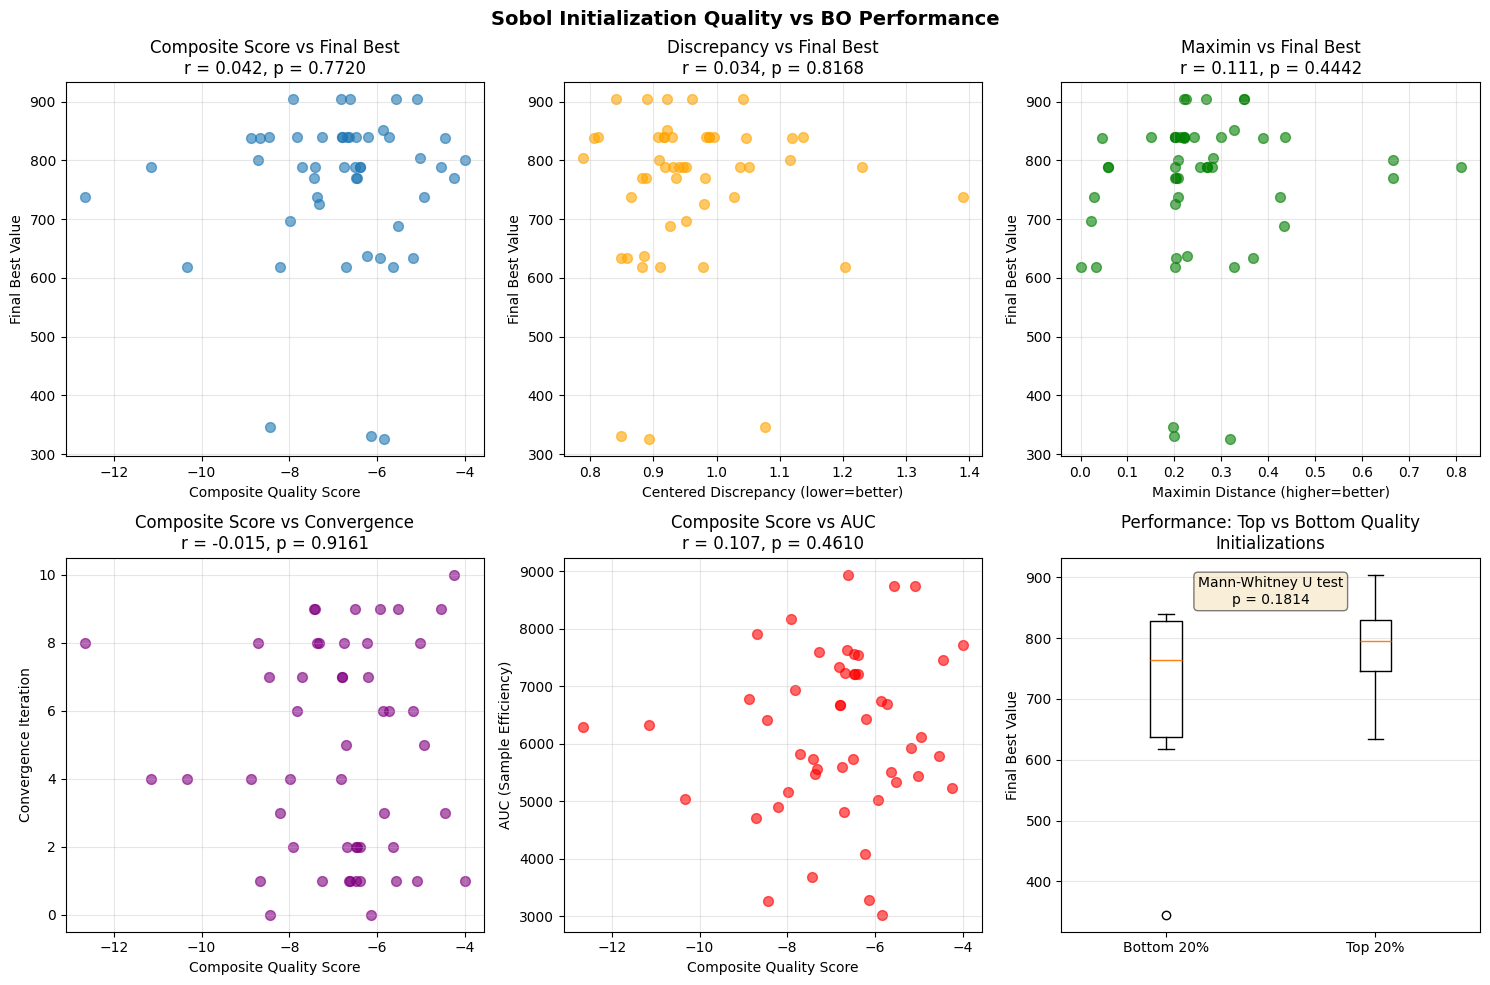

In [11]:
plot_correlation_analysis(results)

In [10]:
lookup = load_lookup_csv("P3HT_dataset.csv")
results = study_sobol_quality_vs_performance(
    lookup,
    n_init=5,
    n_iter=10,
    n_seeds=50
)

Running study with 50 different Sobol initializations...
Dimensionality: 5, Table size: 233
Initial points: 5, BO iterations: 10

Completed 10/50 runs
Completed 20/50 runs
Completed 30/50 runs
Completed 40/50 runs
Completed 50/50 runs


In [7]:
results

,seed,centered_discrepancy,maximin_distance,mean_distance,std_distance,max_proj_discrepancy,composite_score,best_values,final_best,convergence_iter,auc,early_improvement,late_improvement,total_improvement
0,0,0.173072,0.492184,0.869533,0.213519,0.057534,2.469264,"[0.8459648489952087, 0.8459648489952087, 0.845...",0.908576,0,8.851978,0.055289,0.007322,0.062611
1,1,0.177762,0.400948,0.882677,0.191113,0.060894,1.992471,"[0.7980245351791382, 0.7980245351791382, 0.798...",0.908576,3,8.673863,0.097435,0.013117,0.110552
2,2,0.298928,0.311478,0.875304,0.352148,0.100325,0.318719,"[0.8691175580024719, 0.8691175580024719, 0.901...",0.908576,0,8.997285,0.032136,0.007322,0.039459
3,3,0.189503,0.574962,0.965306,0.174226,0.060907,2.910393,"[0.7980245351791382, 0.7980245351791382, 0.798...",0.869118,0,8.442350,0.071093,0.000000,0.071093
4,4,0.191727,0.410615,0.847332,0.230382,0.072273,1.830467,"[0.7287301421165466, 0.8643076419830322, 0.864...",0.908576,1,8.845983,0.166729,0.013117,0.179846
5,5,0.225935,0.574962,0.866960,0.173069,0.082475,2.349386,"[0.7835547924041748, 0.8358350396156311, 0.901...",0.908576,1,8.935866,0.125021,0.000000,0.125021
6,6,0.166189,0.677880,0.932090,0.168784,0.046907,3.591687,"[0.7667948603630066, 0.8337821960449219, 0.864...",0.906220,1,8.821166,0.137080,0.002346,0.139426
7,7,0.229068,0.688661,0.946720,0.191972,0.087060,3.046064,"[0.812000036239624, 0.8358350396156311, 0.8730...",0.903875,1,8.832421,0.091875,0.000000,0.091875
8,8,0.173954,0.465123,0.838964,0.190343,0.065150,2.264006,"[0.7911561727523804, 0.7911561727523804, 0.791...",0.901393,6,8.190853,0.016043,0.094194,0.110237
9,9,0.214827,0.536383,0.834920,0.161209,0.086462,2.203482,"[0.6948647499084473, 0.8459648489952087, 0.901...",0.908576,1,8.887006,0.206389,0.007322,0.213712
